# Usage (quick version)

## Preparation

In [1]:
# Standard users
# !pip install covsirphy
# Developers (Note: this notebook is in example directory)
import os
os.chdir("../")

In [2]:
import warnings

In [3]:
import covsirphy as cs
cs.__version__

'2.8.3-alpha.new.224'

## Dataset preparation
Download the datasets to "input" direcotry and load them.

If "input" directory has the datasets, `DataLoader` will load the local files. If the datasets were updated in remote servers, `DataLoader` will update the local files automatically.
Download the datasets to "input" direcotry and load them.

If "input" directory has the datasets, `DataLoader` will load the local files. If the datasets were updated in remote servers, `DataLoader` will update the local files automatically.

In [4]:
data_loader = cs.DataLoader("input")
# The number of cases (JHU style)
jhu_data = data_loader.jhu(verbose=True)
# Population in each country
population_data = data_loader.population(verbose=True)
# Government Response Tracker (OxCGRT)
oxcgrt_data = data_loader.oxcgrt(verbose=True)

Retrieving datasets from COVID-19 Data Hub: https://covid19datahub.io/


Detailed citaition list:

Open Government Data, United Kingdom (2020), https://coronavirus.data.gov.uk
Department of Disease Control of Thailand (2020), https://covid19.th-stat.com/
World Health Organization (2020), https://covid19.who.int
Ireland Health Protection Surveillance Centre (HPSC) and Health Service Executive (HSE) (2020), https://covid19ireland-geohive.hub.arcgis.com/
The COVID Tracking Project (2020), https://covidtracking.com
Ministry of Health of Croatia (2020), https://data.gov.hr/dataset/koronavirus/resource/08fab529-ebba-46c7-be79-05782ddb02ef
Open Government Data, Latvia (2020), https://data.gov.lv/dati/dataset
Taiwan Ministry of Health and Welfare (2020), https://data.gov.tw/dataset/120451
Wikipedia (2020), https://en.wikipedia.org/wiki
Epistat, Belgian Infectious Diseases (2020), https://epistat.sciensano.be
Johns Hopkins Center for Systems Science and Engineering (2020), https://github.com/CSSEGISandData/COVID-19
Covid19data.com.au (2020), https://github.com/M3IT/COVID-19_Data
Data Science

### The number of cases (JHU style)

In [5]:
# Description/citation
print(jhu_data.citation)

(Secondary source) Guidotti, E., Ardia, D., (2020), "COVID-19 Data Hub", Journal of Open Source Software 5(51):2376, doi: 10.21105/joss.02376.
We can get Citation list of primary sources with DataLoader(...).covid19dh_citation

In [6]:
print(data_loader.covid19dh_citation)

Open Government Data, United Kingdom (2020), https://coronavirus.data.gov.uk
Department of Disease Control of Thailand (2020), https://covid19.th-stat.com/
World Health Organization (2020), https://covid19.who.int
Ireland Health Protection Surveillance Centre (HPSC) and Health Service Executive (HSE) (2020), https://covid19ireland-geohive.hub.arcgis.com/
The COVID Tracking Project (2020), https://covidtracking.com
Ministry of Health of Croatia (2020), https://data.gov.hr/dataset/koronavirus/resource/08fab529-ebba-46c7-be79-05782ddb02ef
Open Government Data, Latvia (2020), https://data.gov.lv/dati/dataset
Taiwan Ministry of Health and Welfare (2020), https://data.gov.tw/dataset/120451
Wikipedia (2020), https://en.wikipedia.org/wiki
Epistat, Belgian Infectious Diseases (2020), https://epistat.sciensano.be
Johns Hopkins Center for Systems Science and Engineering (2020), https://github.com/CSSEGISandData/COVID-19
Covid19data.com.au (2020), https://github.com/M3IT/COVID-19_Data
Data Science

In [7]:
# Raw data
jhu_data.raw.tail()

,ObservationDate,Confirmed,Recovered,Deaths,Population,ISO3,Province/State,Country/Region,school_closing,workplace_closing,cancel_events,gatherings_restrictions,transport_closing,stay_home_restrictions,internal_movement_restrictions,international_movement_restrictions,information_campaigns,testing_policy,contact_tracing,stringency_index
280726,2020-10-08,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,0,0,4,2,2,2,62.04
280727,2020-10-09,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,0,0,4,2,2,2,62.04
280728,2020-10-10,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,0,0,4,2,2,2,62.04
280729,2020-10-11,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,0,0,4,2,2,2,62.04
280730,2020-10-12,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,0,0,4,2,2,2,62.04


In [8]:
# Cleaned data
jhu_data.cleaned().tail()

,Date,Country,Province,Confirmed,Infected,Fatal,Recovered
280726,2020-10-08,Colombia,Vichada,14,0,0,14
280727,2020-10-09,Colombia,Vichada,14,0,0,14
280728,2020-10-10,Colombia,Vichada,14,0,0,14
280729,2020-10-11,Colombia,Vichada,14,0,0,14
280730,2020-10-12,Colombia,Vichada,14,0,0,14


In [9]:
# Subset for a country
jhu_data.subset("Japan", province="Tokyo").tail()

,Date,Confirmed,Infected,Fatal,Recovered
203,2020-10-08,27117,2115,417,24585
204,2020-10-09,27320,2126,421,24773
205,2020-10-10,27569,2162,421,24986
206,2020-10-11,27715,2150,421,25144
207,2020-10-12,27793,2228,421,25144


In [10]:
# Total
total_df = jhu_data.total()
total_df.tail()

,Confirmed,Infected,Fatal,Recovered,Fatal per Confirmed,Recovered per Confirmed,Fatal per (Fatal or Recovered)
Date,,,,,,,
2020-10-08,36148113,10017424,1054861,25075828,0.014591,0.346848,0.040369
2020-10-09,36499896,10162119,1060638,25277139,0.014529,0.346263,0.040271
2020-10-10,36808887,10280317,1064688,25463882,0.014462,0.345893,0.040134
2020-10-11,37104131,10364718,1069000,25670413,0.014405,0.345924,0.039978
2020-10-12,37104562,10446309,1069004,25589249,0.014405,0.344826,0.040100


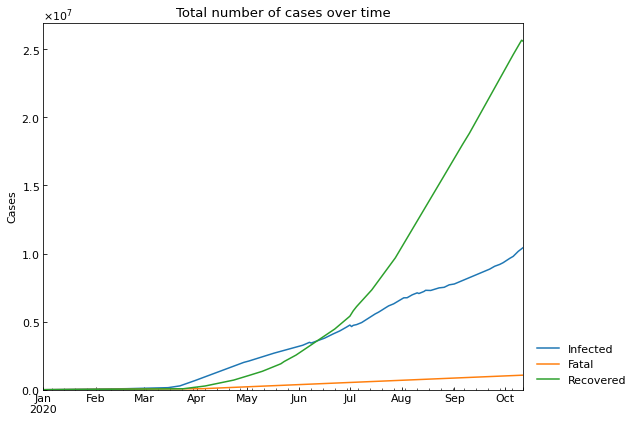

In [11]:
# Plot the total values
cs.line_plot(total_df[["Infected", "Fatal", "Recovered"]], "Total number of cases over time")

### (Optional) Replace the dataset in Japan


In [12]:
jhu_data.subset("Japan").tail()

,Date,Confirmed,Infected,Fatal,Recovered
242,2020-10-08,87667,5837,1618,80212
243,2020-10-09,88268,5928,1624,80716
244,2020-10-10,88949,5996,1627,81326
245,2020-10-11,89386,5952,1629,81805
246,2020-10-12,89664,88031,1633,80725


In [13]:
japan_data = data_loader.japan()
print(japan_data.citation)

Lisphilar (2020), COVID-19 dataset in Japan, GitHub repository, https://github.com/lisphilar/covid19-sir/data/japan

In [14]:
jhu_data.replace(japan_data)
jhu_data.subset("Japan").tail()

,Date,Confirmed,Infected,Fatal,Recovered
240,2020-10-08,87020,5180,1613,80227
241,2020-10-09,87639,5290,1616,80733
242,2020-10-10,88233,5253,1624,81356
243,2020-10-11,88912,5461,1627,81824
244,2020-10-12,89347,5605,1629,82113


### Population in each country

In [15]:
# Description/citation
print(population_data.citation)

(Secondary source) Guidotti, E., Ardia, D., (2020), "COVID-19 Data Hub", Journal of Open Source Software 5(51):2376, doi: 10.21105/joss.02376.
We can get Citation list of primary sources with DataLoader(...).covid19dh_citation

In [16]:
# Raw data (the same as jhu_data)
population_data.raw.tail()

,ObservationDate,Confirmed,Recovered,Deaths,Population,ISO3,Province/State,Country/Region,school_closing,workplace_closing,cancel_events,gatherings_restrictions,transport_closing,stay_home_restrictions,internal_movement_restrictions,international_movement_restrictions,information_campaigns,testing_policy,contact_tracing,stringency_index
280726,2020-10-08,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,0,0,4,2,2,2,62.04
280727,2020-10-09,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,0,0,4,2,2,2,62.04
280728,2020-10-10,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,0,0,4,2,2,2,62.04
280729,2020-10-11,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,0,0,4,2,2,2,62.04
280730,2020-10-12,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,0,0,4,2,2,2,62.04


In [17]:
# Cleaned data
population_data.cleaned().tail()

,ISO3,Country,Province,Date,Population
239751,COL,Colombia,Vichada,2020-10-08,107808
239752,COL,Colombia,Vichada,2020-10-09,107808
239753,COL,Colombia,Vichada,2020-10-10,107808
239754,COL,Colombia,Vichada,2020-10-11,107808
239755,COL,Colombia,Vichada,2020-10-12,107808


In [18]:
population_data.value("Japan", province=None)

126529100

In [19]:
# Register population value of Tokyo in Japan
# https://www.metro.tokyo.lg.jp/tosei/hodohappyo/press/2020/06/11/07.html
population_data.update(14_002_973, "Japan", province="Tokyo")
population_data.value("Japan", province="Tokyo")

14002973

### Government Response Tracker (OxCGRT)

In [20]:
# Description/citation
print(oxcgrt_data.citation)

(Secondary source) Guidotti, E., Ardia, D., (2020), "COVID-19 Data Hub", Journal of Open Source Software 5(51):2376, doi: 10.21105/joss.02376.
We can get Citation list of primary sources with DataLoader(...).covid19dh_citation

In [21]:
# Raw data (the same as jhu_data)
oxcgrt_data.raw.tail()

,ObservationDate,Confirmed,Recovered,Deaths,Population,ISO3,Province/State,Country/Region,school_closing,workplace_closing,cancel_events,gatherings_restrictions,transport_closing,stay_home_restrictions,internal_movement_restrictions,international_movement_restrictions,information_campaigns,testing_policy,contact_tracing,stringency_index
280726,2020-10-08,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,0,0,4,2,2,2,62.04
280727,2020-10-09,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,0,0,4,2,2,2,62.04
280728,2020-10-10,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,0,0,4,2,2,2,62.04
280729,2020-10-11,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,0,0,4,2,2,2,62.04
280730,2020-10-12,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,0,0,4,2,2,2,62.04


In [22]:
# Cleaned data
oxcgrt_data.cleaned().tail()

,Date,Country,ISO3,School_closing,Workplace_closing,Cancel_events,Gatherings_restrictions,Transport_closing,Stay_home_restrictions,Internal_movement_restrictions,International_movement_restrictions,Information_campaigns,Testing_policy,Contact_tracing,Stringency_index
280726,2020-10-08,Colombia,COL,3,1,2,3,1,0,0,4,2,2,2,62.04
280727,2020-10-09,Colombia,COL,3,1,2,3,1,0,0,4,2,2,2,62.04
280728,2020-10-10,Colombia,COL,3,1,2,3,1,0,0,4,2,2,2,62.04
280729,2020-10-11,Colombia,COL,3,1,2,3,1,0,0,4,2,2,2,62.04
280730,2020-10-12,Colombia,COL,3,1,2,3,1,0,0,4,2,2,2,62.04


In [23]:
# Subset for a country
oxcgrt_data.subset("Japan").tail()

,Date,School_closing,Workplace_closing,Cancel_events,Gatherings_restrictions,Transport_closing,Stay_home_restrictions,Internal_movement_restrictions,International_movement_restrictions,Information_campaigns,Testing_policy,Contact_tracing,Stringency_index
281,2020-10-08,1,1,1,0,0,1,1,1,2,2,1,31.48
282,2020-10-09,1,1,1,0,0,1,1,1,2,2,1,31.48
283,2020-10-10,1,1,1,0,0,1,1,1,2,2,1,31.48
284,2020-10-11,1,1,1,0,0,1,1,1,2,2,1,31.48
285,2020-10-12,1,1,1,0,0,1,1,1,2,2,1,31.48


In [24]:
# Subset for a country (using ISO3 code)
oxcgrt_data.subset("JPN").tail()

,Date,School_closing,Workplace_closing,Cancel_events,Gatherings_restrictions,Transport_closing,Stay_home_restrictions,Internal_movement_restrictions,International_movement_restrictions,Information_campaigns,Testing_policy,Contact_tracing,Stringency_index
281,2020-10-08,1,1,1,0,0,1,1,1,2,2,1,31.48
282,2020-10-09,1,1,1,0,0,1,1,1,2,2,1,31.48
283,2020-10-10,1,1,1,0,0,1,1,1,2,2,1,31.48
284,2020-10-11,1,1,1,0,0,1,1,1,2,2,1,31.48
285,2020-10-12,1,1,1,0,0,1,1,1,2,2,1,31.48


## Scenario analysis
As an example, we will analysis the number of cases in Japan.

In [25]:
scenario = cs.Scenario(jhu_data, population_data, country="Japan", province=None)

### Check records

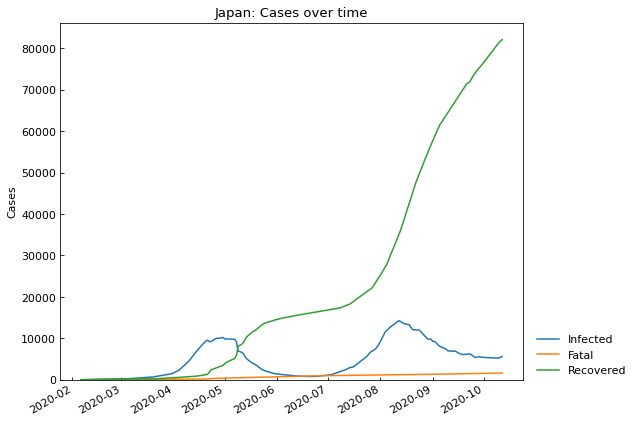

,Date,Confirmed,Infected,Fatal,Recovered
240,2020-10-08,87020,5180,1613,80227
241,2020-10-09,87639,5290,1616,80733
242,2020-10-10,88233,5253,1624,81356
243,2020-10-11,88912,5461,1627,81824
244,2020-10-12,89347,5605,1629,82113


In [26]:
import matplotlib
warnings.simplefilter("ignore", category=matplotlib.MatplotlibDeprecationWarning)
record_df = scenario.records()
record_df.tail()

### S-R trend analysis

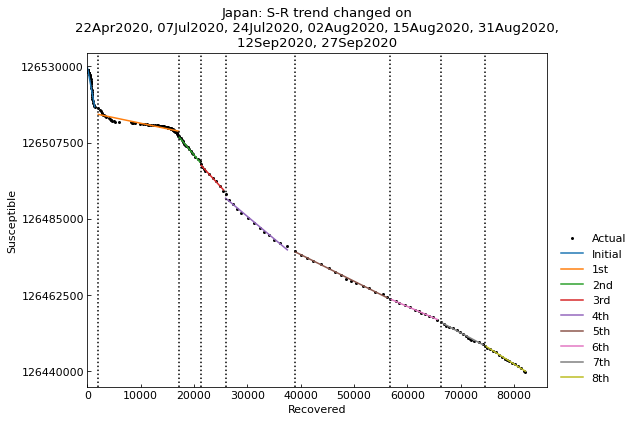

,Type,Start,End,Population
0th,Past,06Feb2020,21Apr2020,126529100
1st,Past,22Apr2020,06Jul2020,126529100
2nd,Past,07Jul2020,23Jul2020,126529100
3rd,Past,24Jul2020,01Aug2020,126529100
4th,Past,02Aug2020,14Aug2020,126529100
5th,Past,15Aug2020,30Aug2020,126529100
6th,Past,31Aug2020,11Sep2020,126529100
7th,Past,12Sep2020,26Sep2020,126529100
8th,Past,27Sep2020,12Oct2020,126529100


In [27]:
scenario.trend(set_phases=True)
scenario.summary()

### Hyperparameter estimation of ODE models
As an example, use SIR-F model.
We can use SIR, SIRD, (SIRFV), (SEWIRF).

In [28]:
scenario.estimate(cs.SIRF)


<SIR-F model: parameter estimation>

Running optimization with 4 CPUs...

	8th phase (27Sep2020 - 12Oct2020): finished  383 trials in 0 min 20 sec

	2nd phase (07Jul2020 - 23Jul2020): finished  664 trials in 0 min 35 sec

	3rd phase (24Jul2020 - 01Aug2020): finished 1077 trials in 1 min  0 sec

	1st phase (22Apr2020 - 06Jul2020): finished 1012 trials in 1 min  0 sec

	0th phase (06Feb2020 - 21Apr2020): finished  962 trials in 1 min  0 sec

	6th phase (31Aug2020 - 11Sep2020): finished  235 trials in 0 min 10 sec

	7th phase (12Sep2020 - 26Sep2020): finished  230 trials in 0 min 10 sec

	5th phase (15Aug2020 - 30Aug2020): finished  557 trials in 0 min 25 sec

	4th phase (02Aug2020 - 14Aug2020): finished 1188 trials in 1 min  0 sec

Completed optimization. Total: 1 min 56 sec

In [29]:
scenario.summary()

,Type,Start,End,Population,ODE,Rt,theta,kappa,rho,sigma,tau,1/beta [day],1/alpha2 [day],1/gamma [day],alpha1 [-],RMSLE,Trials,Runtime
0th,Past,06Feb2020,21Apr2020,126529100,SIR-F,4.24,0.018514,0.000338,0.032275,0.007136,480,10,985,46,0.019,1.287716,962,1 min 0 sec
1st,Past,22Apr2020,06Jul2020,126529100,SIR-F,0.41,0.022132,0.000894,0.009950,0.023067,480,33,373,14,0.022,0.973113,1012,1 min 0 sec
2nd,Past,07Jul2020,23Jul2020,126529100,SIR-F,1.89,0.000158,0.000060,0.045682,0.024089,480,7,5573,13,0.000,0.030921,664,0 min 35 sec
3rd,Past,24Jul2020,01Aug2020,126529100,SIR-F,1.75,0.001692,0.000041,0.045933,0.026096,480,7,8228,12,0.002,0.020177,1077,1 min 0 sec
4th,Past,02Aug2020,14Aug2020,126529100,SIR-F,1.48,0.000281,0.000137,0.033060,0.022133,480,10,2441,15,0.000,0.070780,1188,1 min 0 sec
5th,Past,15Aug2020,30Aug2020,126529100,SIR-F,0.79,0.000121,0.000294,0.027333,0.034374,480,12,1134,9,0.000,0.032898,557,0 min 25 sec
6th,Past,31Aug2020,11Sep2020,126529100,SIR-F,0.69,0.023906,0.000014,0.023227,0.032939,480,14,23434,10,0.024,0.016627,235,0 min 10 sec
7th,Past,12Sep2020,26Sep2020,126529100,SIR-F,0.81,0.004542,0.000299,0.028079,0.034123,480,11,1115,9,0.005,0.051641,230,0 min 10 sec
8th,Past,27Sep2020,12Oct2020,126529100,SIR-F,0.97,0.002477,0.000167,0.033992,0.034922,480,9,1999,9,0.002,0.022525,383,0 min 20 sec


### Accuracy of estimation

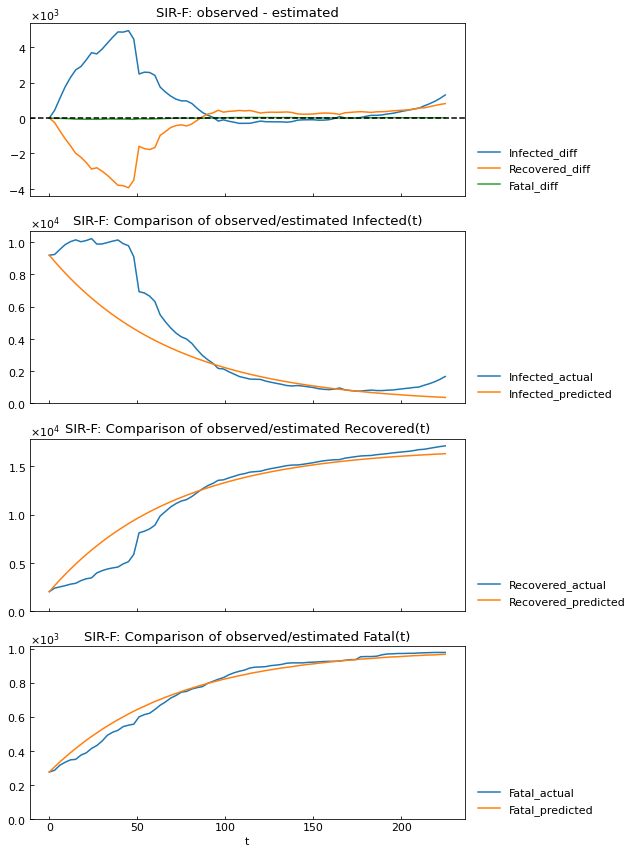

In [30]:
scenario.estimate_accuracy(phase="1st")

### Get parameter value

In [31]:
scenario.get("Rt", phase="4th")

1.48

### Show parameter history

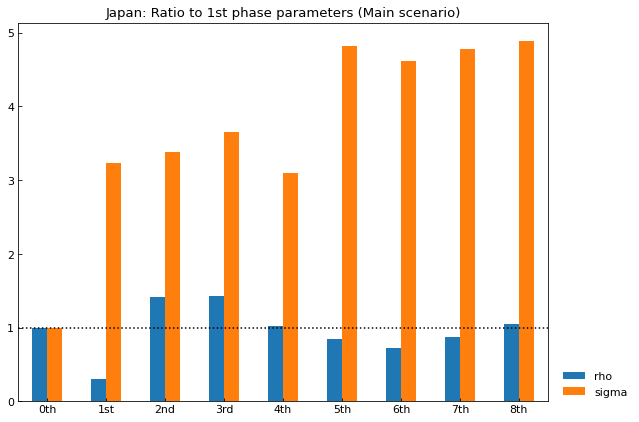

,0th,1st,2nd,3rd,4th,5th,6th,7th,8th
rho,1.0,0.308295,1.415375,1.423168,1.024315,0.846874,0.719664,0.869978,1.053176
sigma,1.0,3.232305,3.375509,3.656815,3.101452,4.816656,4.615581,4.781552,4.893514


In [32]:
df = scenario.param_history(targets=["rho", "sigma"])
df.T

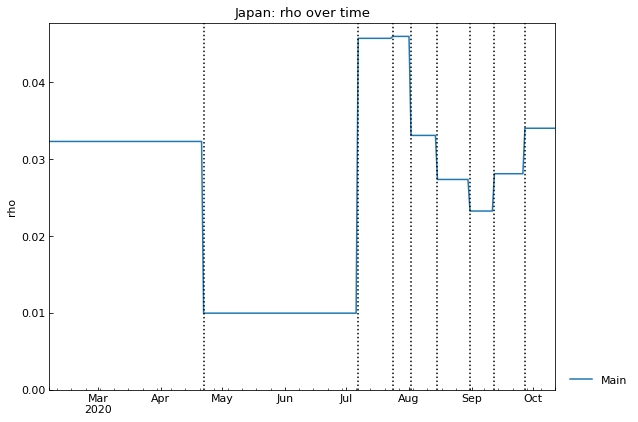

In [33]:
_ = scenario.history(target="rho")

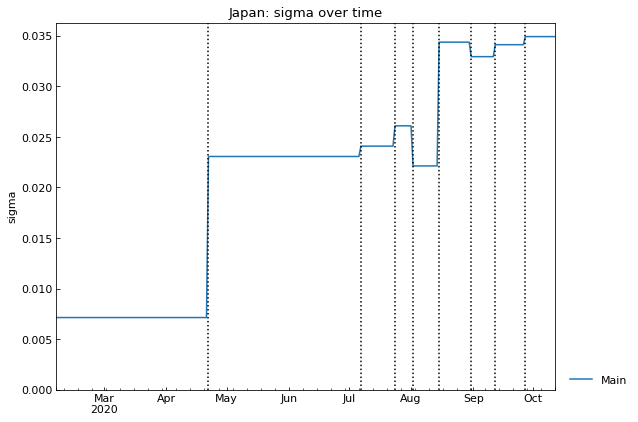

In [34]:
_ = scenario.history(target="sigma")

### Show the history of reproduction number

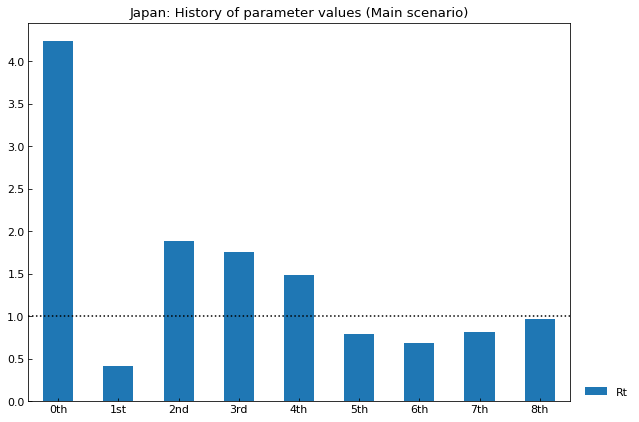

,0th,1st,2nd,3rd,4th,5th,6th,7th,8th
Rt,4.24,0.41,1.89,1.75,1.48,0.79,0.69,0.81,0.97


In [35]:
df = scenario.param_history(targets=["Rt"], divide_by_first=False, show_box_plot=True)
df.T

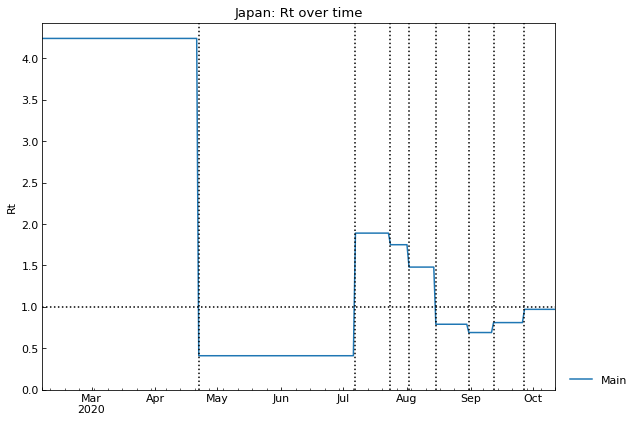

In [36]:
_ = scenario.history(target="Rt")

### Simulate the number of cases

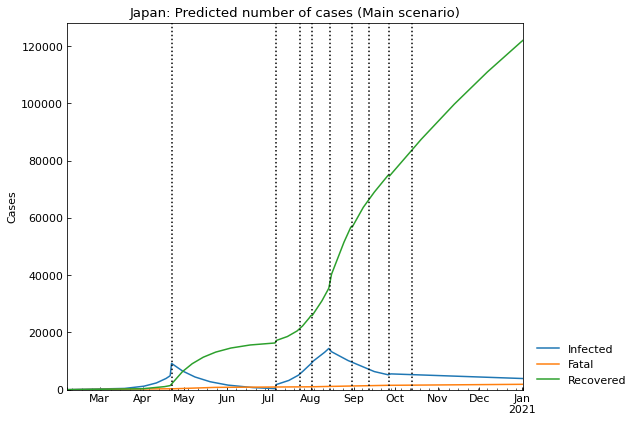

,Date,Confirmed,Fatal,Infected,Recovered
327,2020-12-29,126244,1874,3952,120418
328,2020-12-30,126646,1877,3938,120831
329,2020-12-31,127046,1880,3923,121243
330,2021-01-01,127445,1883,3909,121653
331,2021-01-02,127843,1886,3895,122062


In [37]:
scenario.clear(name="Main")
scenario.add(end_date="01Jan2021", name="Main")
main_sim_df = scenario.simulate(name="Main")
main_sim_df.tail()

### Simulate another scenario
If $\sigma$ will be double in 30 days, how many cases will be?

In [38]:
sigma_current = scenario.get("sigma", name="Main", phase="last")
sigma_current

0.034922027715609656

In [39]:
sigma_new = sigma_current * 2
sigma_new

0.06984405543121931

In [40]:
scenario.clear(name="Medicine")
scenario.add(name="Medicine", days=30, sigma=sigma_current)
scenario.add(name="Medicine", end_date="01Jan2021", sigma=sigma_new)
scenario.summary()

Type      Start        End  Population    ODE    Rt  \
Scenario Phase                                                          
Main     0th      Past  06Feb2020  21Apr2020   126529100  SIR-F  4.24   
         1st      Past  22Apr2020  06Jul2020   126529100  SIR-F  0.41   
         2nd      Past  07Jul2020  23Jul2020   126529100  SIR-F  1.89   
         3rd      Past  24Jul2020  01Aug2020   126529100  SIR-F  1.75   
         4th      Past  02Aug2020  14Aug2020   126529100  SIR-F  1.48   
         5th      Past  15Aug2020  30Aug2020   126529100  SIR-F  0.79   
         6th      Past  31Aug2020  11Sep2020   126529100  SIR-F  0.69   
         7th      Past  12Sep2020  26Sep2020   126529100  SIR-F  0.81   
         8th      Past  27Sep2020  12Oct2020   126529100  SIR-F  0.97   
         9th    Future  13Oct2020  01Jan2021   126529100  SIR-F  0.97   
Medicine 0th      Past  06Feb2020  21Apr2020   126529100  SIR-F  4.24   
         1st      Past  22Apr2020  06Jul2020   126529100  SIR-F  0.41   
         2nd      Past  07Jul2020  23Jul2020   126529100  SIR-F  1.89   
         3rd      Past  24Jul2020  01Aug2020   126529100  SIR-F  1.75   
         4th      Past  02Aug2020  14Aug2020   126529100  SIR-F  1.48   
         5th      Past  15Aug2020  30Aug2020   126529100  SIR-F  0.79   
         6th      Past  31Aug2020  11Sep2020   126529100  SIR-F  0.69   
         7th      Past  12Sep2020  26Sep2020   126529100  SIR-F  0.81   
         8th      Past  27Sep2020  12Oct2020   126529100  SIR-F  0.97   
         9th    Future  13Oct2020  11Nov2020   126529100  SIR-F  0.97   
         10th   Future  12Nov2020  01Jan2021   126529100  SIR-F  0.48   

                   theta     kappa       rho     sigma  tau  1/beta [day]  \
Scenario Phase                                                              
Main     0th    0.018514  0.000338  0.032275  0.007136  480            10   
         1st    0.022132  0.000894  0.009950  0.023067  480            33   
         2nd    0.000158  0.000060  0.045682  0.024089  480             7   
         3rd    0.001692  0.000041  0.045933  0.026096  480             7   
         4th    0.000281  0.000137  0.033060  0.022133  480            10   
         5th    0.000121  0.000294  0.027333  0.034374  480            12   
         6th    0.023906  0.000014  0.023227  0.032939  480            14   
         7th    0.004542  0.000299  0.028079  0.034123  480            11   
         8th    0.002477  0.000167  0.033992  0.034922  480             9   
         9th    0.002477  0.000167  0.033992  0.034922  480             9   
Medicine 0th    0.018514  0.000338  0.032275  0.007136  480            10   
         1st    0.022132  0.000894  0.009950  0.023067  480            33   
         2nd    0.000158  0.000060  0.045682  0.024089  480             7   
         3rd    0.001692  0.000041  0.045933  0.026096  480             7   
         4th    0.000281  0.000137  0.033060  0.022133  480            10   
         5th    0.000121  0.000294  0.027333  0.034374  480            12   
         6th    0.023906  0.000014  0.023227  0.032939  480            14   
         7th    0.004542  0.000299  0.028079  0.034123  480            11   
         8th    0.002477  0.000167  0.033992  0.034922  480             9   
         9th    0.002477  0.000167  0.033992  0.034922  480             9   
         10th   0.002477  0.000167  0.033992  0.069844  480             9   

                1/alpha2 [day]  1/gamma [day]  alpha1 [-]      RMSLE Trials  \
Scenario Phase                                                                
Main     0th               985             46       0.019    1.28772    962   
         1st               373             14       0.022   0.973113   1012   
         2nd              5573             13       0.000  0.0309212    664   
         3rd              8228             12       0.002  0.0201773   1077   
         4th              2441             15       0.000  0.0707798   1188   
         5th 

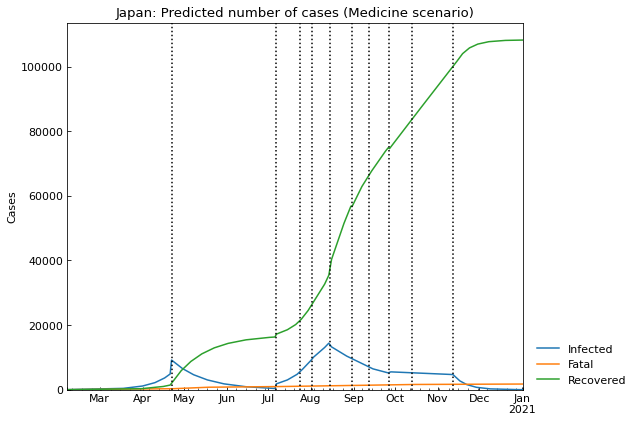

,Date,Confirmed,Fatal,Infected,Recovered
327,2020-12-29,109986,1754,29,108203
328,2020-12-30,109989,1754,26,108209
329,2020-12-31,109991,1754,23,108214
330,2021-01-01,109994,1754,21,108219
331,2021-01-02,109996,1754,19,108223


In [41]:
scenario.simulate(name="Medicine").tail()

### Compare the scenarios

In [42]:
scenario.describe()

,max(Infected),argmax(Infected),Infected on 02Jan2021,Fatal on 02Jan2021,10th_Rt
Main,14400,14Aug2020,3895,1886,-
Medicine,14400,14Aug2020,19,1754,0.48


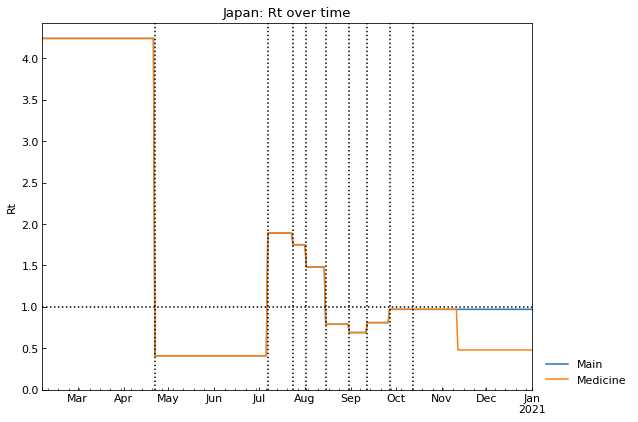

In [43]:
_ = scenario.history(target="Rt")

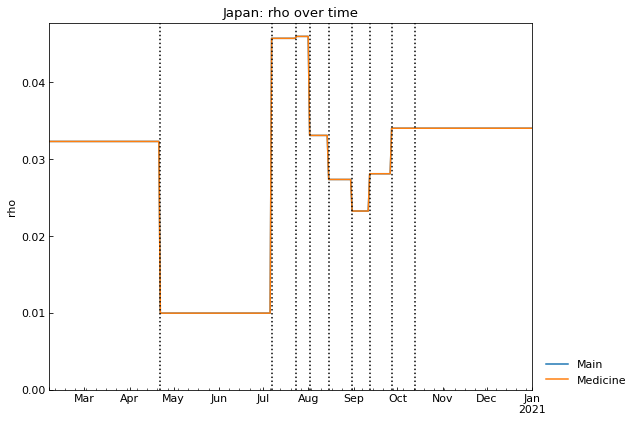

In [44]:
_ = scenario.history(target="rho")

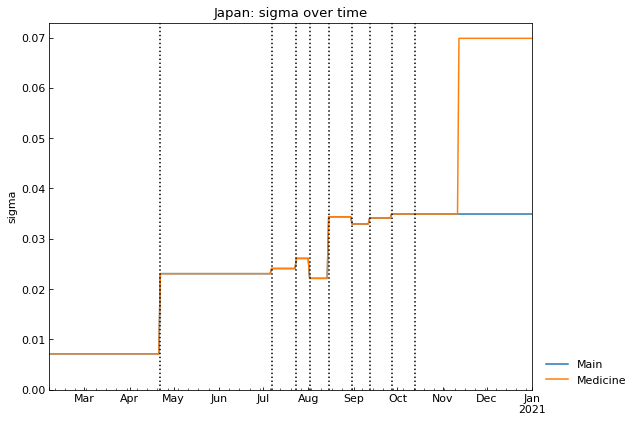

In [45]:
_ = scenario.history(target="sigma")

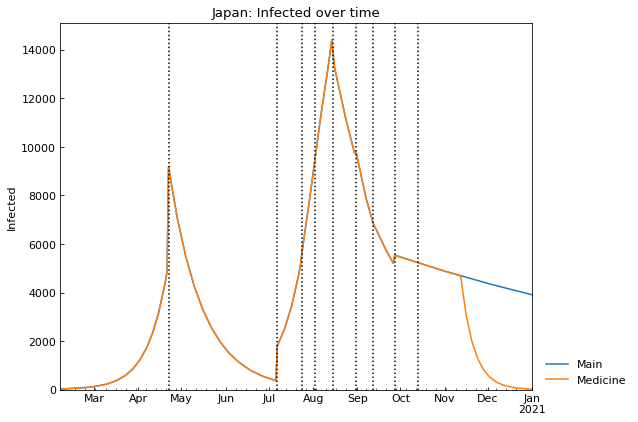

In [46]:
_ = scenario.history(target="Infected")

### Change rate of parameters in main scenario

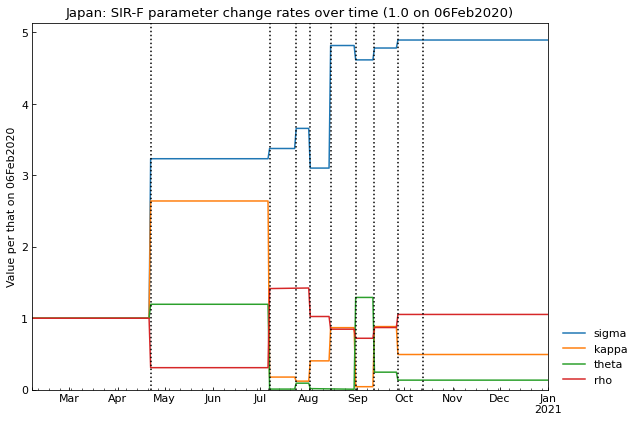

In [47]:
# >= 2.8.3-alpha.new.224 (will be included in 2.9.0)
_ = scenario.history_rate(name="Main")